In [1]:
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
import networkx as nx
import folium
import numba

from itertools import pairwise
from folium.vector_layers import PolyLine, CircleMarker
from pyquadkey2 import quadkey
from pyquadkey2.quadkey import TileAnchor, QuadKey
from numba import jit

In [2]:
g = ox.graph_from_place('Ann Arbor, Michigan', network_type='drive', simplify=False)

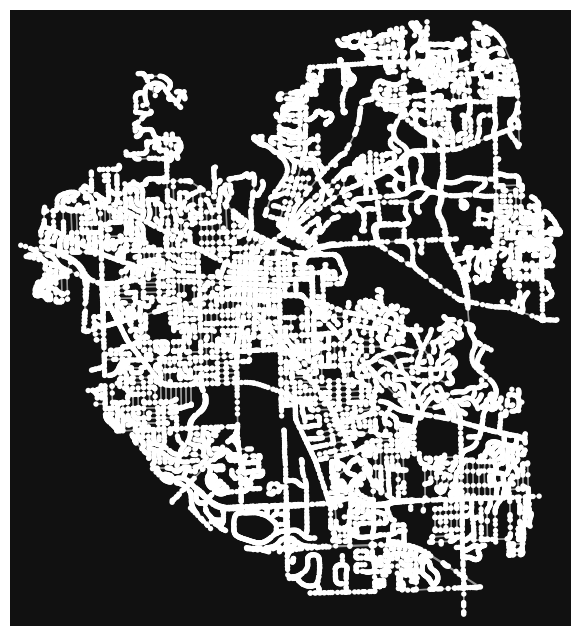

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [3]:
ox.plot_graph(g)

In [4]:
g = ox.add_edge_speeds(g)

In [5]:
g = ox.add_edge_travel_times(g)

In [6]:
g = ox.bearing.add_edge_bearings(g)

The code below was slightly adapted from https://max-coding.medium.com/osmnx-part-1-loading-data-from-open-street-maps-and-finding-shortest-route-between-two-points-5bb073b0a27d

In [7]:
def geocode_address(address, crs=4326):
    geocode = gpd.tools.geocode(address, provider='nominatim', 
                user_agent="QuadKey speedster").to_crs(crs)
    return (geocode.iloc[0].geometry.y, geocode.iloc[0].geometry.x)

In [8]:
addr_ini = "122 N Thayer St, Ann Arbor, MI 48104, USA"
addr_end = "1431 Ardmoor Ave, Ann Arbor, MI 48103, USA"

In [9]:
loc_ini = geocode_address(addr_ini)
loc_end = geocode_address(addr_end)

In [10]:
node_ini = ox.distance.nearest_nodes(g, loc_ini[1], loc_ini[0])
node_end = ox.distance.nearest_nodes(g, loc_end[1], loc_end[0])

In [11]:
route = nx.shortest_path(g, node_ini, node_end, weight='travel_time')

In [12]:
def fit_bounding_box(html_map, bb_list):
    if isinstance(bb_list, list):
        ll = np.array(bb_list)
    else:
        ll = bb_list
        
    min_lat, max_lat = ll[:, 0].min(), ll[:, 0].max()
    min_lon, max_lon = ll[:, 1].min(), ll[:, 1].max()
    html_map.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
    return html_map

In [13]:
def swap_coordinates(coords):
    return [(p[1], p[0]) for p in coords]

In [14]:
def linestring_to_polyline(linestring):
    line = [(p[1], p[0]) for p in list(linestring.coords)]
    return PolyLine(line, weight=2, opacity=0.5)

In [15]:
def map_route(g, route):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron", max_zoom=20, control_scale=True)
    
    empty_edges = []
    bb_list = []
    
    for n in route:
        loc = g.nodes[n]
        CircleMarker((loc['y'], loc['x']), radius=2, color="red", fill="red", opacity=0.5, tooltip=n, popup=n).add_to(html_map)
        bb_list.append((loc['y'], loc['x']))
    
    for n0, n1 in pairwise(route):
        edge = g[n0][n1]
        l0 = g.nodes[n0]
        l1 = g.nodes[n1]
        line = [(l0['y'], l0['x']), (l1['y'], l1['x'])]
        
        PolyLine(line, weight=3, opacity=0.5, popup=edge[0]).add_to(html_map)
        
    return fit_bounding_box(html_map, bb_list)

In [16]:
map_route(g, route)

In [17]:
g.nodes[62496379]

{'y': 42.2723654, 'x': -83.7495413, 'street_count': 3}

In [18]:
g.nodes[62536102]

{'y': 42.272032, 'x': -83.749647, 'street_count': 3}

In [19]:
def create_map_polygon(xy, tooltip='',
                       color='#3388ff',
                       opacity=0.7,
                       fill_color='#3388ff',
                       fill_opacity=0.4, 
                       weight=1):
    points = [[x[0], x[1]] for x in xy]
    polygon = folium.vector_layers.Polygon(locations=points,
                                           tooltip=tooltip,
                                           fill=True,
                                           color=color,
                                           fill_color=fill_color,
                                           fill_opacity=fill_opacity,
                                           weight=weight,
                                           opacity=opacity)
    return polygon

In [20]:
def create_map_quadkey(qk, tooltip='',
                       color='#3388ff',
                       opacity=0.7,
                       fill_color='#3388ff',
                       fill_opacity=0.0, 
                       weight=1):
    sw = qk.to_geo(anchor=TileAnchor.ANCHOR_SW)
    ne = qk.to_geo(anchor=TileAnchor.ANCHOR_NE)
    # cc = qk.to_geo(anchor=TileAnchor.ANCHOR_CENTER)
    s, w = sw[0], sw[1]
    n, e = ne[0], ne[1]
    points = [[n, e], [s, e], [s, w], [n, w]]
    return create_map_polygon(points, tooltip=tooltip, 
                              color=color, opacity=opacity, 
                              fill_color=fill_color, fill_opacity=fill_opacity,
                              weight=weight)

In [21]:
def map_route_qk_nodes(g, route):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron", max_zoom=20, control_scale=True)
    
    empty_edges = []
    bb_list = []
    
    for n in route:
        loc = g.nodes[n]
        lat = loc['y']
        lon = loc['x']
        CircleMarker((lat, lon), radius=2, color="red", fill="red", opacity=0.5, tooltip=n, popup=n).add_to(html_map)
        bb_list.append((lat, lon))
        
        create_map_quadkey(quadkey.from_geo((lat, lon), 20)).add_to(html_map)
    
    for n0, n1 in pairwise(route):
        edge = g[n0][n1]
        l0 = g.nodes[n0]
        l1 = g.nodes[n1]
        line = [(l0['y'], l0['x']), (l1['y'], l1['x'])]
        
        PolyLine(line, weight=3, opacity=0.5, popup=edge[0]).add_to(html_map)
        
    return fit_bounding_box(html_map, bb_list)    

In [22]:
map_route_qk_nodes(g, route)

In [23]:
def bresenham_line(x0: int, y0: int, x1: int, y1: int):
    line = []
    
    dx = x1 - x0
    dy = y1 - y0
    
    if dy < 0:
        dy = -dy
        step_y = -1
    else:
        step_y = 1
    
    if dx < 0:
        dx = -dx
        step_x = -1
    else:
        step_x = 1
        
    dy = 2 * dy
    dx = 2 * dx
    
    line.append((x0, y0))
    
    if dx > dy:
        fraction = dy - (dx // 2)
        
        while x0 != x1:
            x0 += step_x
            if fraction >= 0:
                y0 += step_y
                fraction -= dx
            fraction += dy
            line.append((x0, y0))
    else:
        fraction = dx - (dy // 2)
        
        while y0 != y1:
            if fraction >= 0:
                x0 += step_x
                fraction -= dy
            y0 += step_y
            fraction += dx
            line.append((x0, y0))
    return line

In [24]:
bresenham_line(0, 0, 20, 10)

[(0, 0),
 (1, 1),
 (2, 1),
 (3, 2),
 (4, 2),
 (5, 3),
 (6, 3),
 (7, 4),
 (8, 4),
 (9, 5),
 (10, 5),
 (11, 6),
 (12, 6),
 (13, 7),
 (14, 7),
 (15, 8),
 (16, 8),
 (17, 9),
 (18, 9),
 (19, 10),
 (20, 10)]

In [25]:
@jit(nopython=True)
def bresenham_pairs(x0: int, y0: int,
                    x1: int, y1: int) -> np.ndarray:
    """Generates the diagonal coordinates

    Parameters
    ----------
    x0 : int
        Origin x value
    y0 : int
        Origin y value
    x1 : int
        Target x value
    y1 : int
        Target y value

    Returns
    -------
    np.ndarray
        Array with the coordinates
    """
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    dim = max(dx, dy)
    pairs = np.zeros((dim, 2), dtype=np.int64)
    x, y = x0, y0
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    if dx > dy:
        err = dx // 2
        for i in range(dx):
            pairs[i, 0] = x
            pairs[i, 1] = y
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy // 2
        for i in range(dy):
            pairs[i, 0] = x
            pairs[i, 1] = y
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    return pairs


In [26]:
bresenham_pairs(0, 0, 10, 10)

array([[0, 0],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 4],
       [5, 5],
       [6, 6],
       [7, 7],
       [8, 8],
       [9, 9]])

In [27]:
%%timeit
bresenham_pairs(0, 0, 1000, 1000)

2.07 µs ± 40.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [28]:
@jit(nopython=True)
def tile_to_qk(x, y, level):
    """
    Converts tile coordinates to a quadkey
    Code adapted from https://docs.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system
    :param x: Tile x coordinate
    :param y: Tile y coordinate
    :param level: Detail leve;
    :return: QuadKey
    """
    q = numba.types.uint64(0)
    for i in range(level, 0, -1):
        mask = 1 << (i - 1)

        q = q << 2
        if (x & mask) != 0:
            q += 1
        if (y & mask) != 0:
            q += 2
    return q

In [29]:
def tile_to_str(x, y, level):
    """
    Converts tile coordinates to a quadkey
    Code adapted from https://docs.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system
    :param x: Tile x coordinate
    :param y: Tile y coordinate
    :param level: Detail leve;
    :return: QuadKey
    """
    q = ""
    for i in range(level, 0, -1):
        mask = 1 << (i - 1)

        c = 0
        if (x & mask) != 0:
            c += 1
        if (y & mask) != 0:
            c += 2
        q = q + str(c)
    return q

In [30]:
def get_qk_line(loc0, loc1, level):
    qk0 = quadkey.from_geo((loc0['y'], loc0['x']), level)
    qk1 = quadkey.from_geo((loc1['y'], loc1['x']), level)
    
    ((tx0, ty0), _) = qk0.to_tile()
    ((tx1, ty1), _) = qk1.to_tile()

    line = bresenham_line(tx0, ty0, tx1, ty1)
    return [quadkey.from_str(tile_to_str(p[0], p[1], level)) for p in line]

In [38]:
def map_route_qk(g, route, level=20):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron", max_zoom=20, control_scale=True)
    
    empty_edges = []
    bb_list = []
    
    for n in route:
        loc = g.nodes[n]
        lat = loc['y']
        lon = loc['x']
        CircleMarker((lat, lon), radius=2, color="red", fill="red", opacity=0.5, tooltip=n, popup=n).add_to(html_map)
        bb_list.append((lat, lon))
    
    for n0, n1 in pairwise(route):
        edge = g[n0][n1]
        l0 = g.nodes[n0]
        l1 = g.nodes[n1]
        line = [(l0['y'], l0['x']), (l1['y'], l1['x'])]
        
        PolyLine(line, weight=3, opacity=0.5, popup=edge[0]).add_to(html_map)
        
        for qk in get_qk_line(l0, l1, level):
            create_map_quadkey(qk).add_to(html_map)
            # print(qk.to_quadint() >> (64-2*level), edge[0]['bearing'])
            
    return fit_bounding_box(html_map, bb_list)    

In [39]:
map_route_qk(g, route)

In [33]:
from db.api import EVedDb

In [34]:
db = EVedDb()

In [35]:
bearings_df = db.query_df("select speed, bearing from signal where quadkey = 217847238132")

In [36]:
import matplotlib.pyplot as plt

(array([  8.,  15.,   6.,  25.,   9.,  11.,  11.,  13.,  15.,  20.,   5.,
          4., 660.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  24.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,  12.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 153.]),
 array([  0.        ,   7.17506878,  14.35013757,  21.52520635,
         28.70027514,  35.87534392,  43.05041271,  50.22548149,
         57.40055028,  64.57561906,  71.75068784,  78.92575663,
         86.10082541,  93.2758942 , 100.45096298, 107.62603177,
        114.80110055, 121.97616934, 129.15123812, 136.3263069 ,
        143.50137569, 150.67644447, 157.85151326, 165.02658204,
        172.20165083, 179.37671961, 186.5517884 , 193.72685718,
        200.90192596, 208.07699475, 215.25206353, 222.42713232,
        229.6022011 , 236.77726989, 243.95233867, 251.12740746,
        258.30247624, 265.47754503, 272.65261381, 279.82768259,
        287.002751

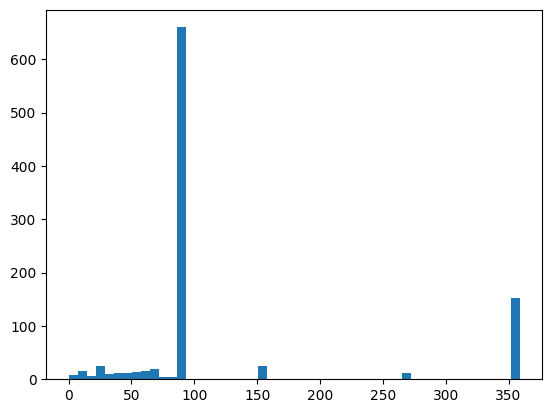

In [37]:
plt.hist(bearings_df["bearing"], bins=50)

In [40]:
day_df = db.query_df("select trunc(day_num) as day, count(0) as n from signal group by trunc(day_num);")

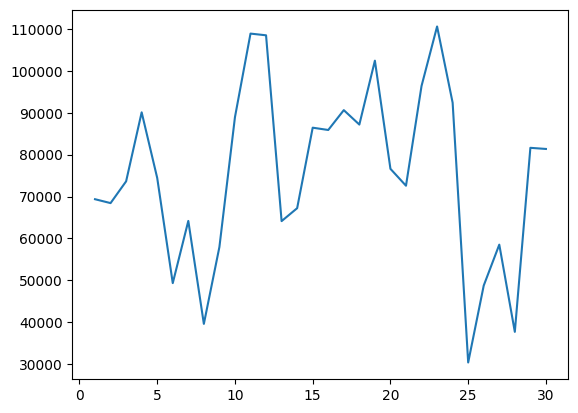

In [47]:
plt.plot(day_df['day'][:30], day_df['n'][:30])

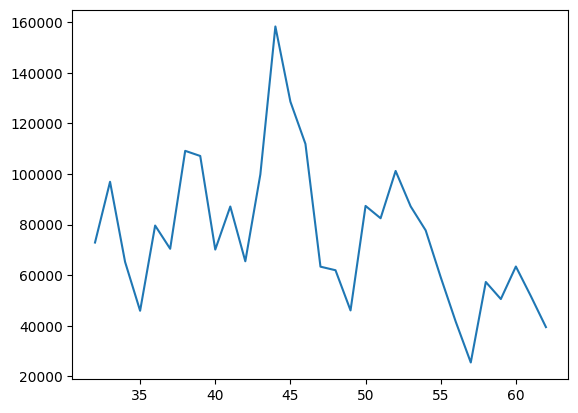

In [48]:
plt.plot(day_df['day'][31:62], day_df['n'][31:62])

In [45]:
day_df['n'][55]

41619